# RNN for Time Series Prediction

This is a time series prediction task. You are given a dataset which reports on the weather and the level of pollution each hour for five years, and asked to train Recurrent Neural Networks (RNNs) to predict the hourly pollution level.

In [1]:
import numpy as np 
import pandas as pd 
import math
from datetime import datetime
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns 
from collections import Counter

from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

%matplotlib inline

D:\Applications\Python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


a) Load the data from the file. Perform necessary pre-processing (e.g., missing value replacement, uninformative attribute removal, etc.) and visualise the values of various attributes over the five-year period.

In [2]:
import os
import sys

# write your code here
DATA_DIR = './data/'
FILENAME = "pollution.csv"
FILE_PATH = os.path.abspath(os.path.join(DATA_DIR, FILENAME))
# print(FILE_PATH)

pollution_df = pd.read_csv(FILE_PATH, index_col="No")


In [3]:

HEAD_COUNT = 10

pollution_df.head(HEAD_COUNT)


,year,month,day,hour,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [4]:

pollution_df["datetime"] = pd.to_datetime(pollution_df[["year", "month", "day", "hour"]])

dt = pollution_df["datetime"]
pollution_df.drop("datetime", axis=1, inplace=True)

# pollution_df.drop("year", axis = 1, inplace=True)
pollution_df.drop("month", axis = 1, inplace=True)
pollution_df.drop("day", axis = 1, inplace=True)
pollution_df.drop("hour", axis = 1, inplace=True)

# pollution_df.insert(0, pollution_df.pop(pollution_df.index("datetime")))
pollution_df.insert(0, "datetime", dt)


In [5]:
pollution_df.head(HEAD_COUNT)

,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
No,,,,,,,,,,
1,2010-01-01 00:00:00,2010,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010-01-01 01:00:00,2010,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010-01-01 02:00:00,2010,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010-01-01 03:00:00,2010,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010-01-01 04:00:00,2010,NaN,-20,-12.0,1018.0,NW,12.97,0,0
6,2010-01-01 05:00:00,2010,NaN,-19,-10.0,1017.0,NW,16.10,0,0
7,2010-01-01 06:00:00,2010,NaN,-19,-9.0,1017.0,NW,19.23,0,0
8,2010-01-01 07:00:00,2010,NaN,-19,-9.0,1017.0,NW,21.02,0,0
9,2010-01-01 08:00:00,2010,NaN,-19,-9.0,1017.0,NW,24.15,0,0


# Handling missing values

### Figuring out how many NaN values there are in the database. 

The empty values can either be dropped entirely, filled with 0's or filled with the mean. In this case, it will be filled with the mean values. 

There are **43824** records in total. Out of that, **2067** records are empty. For these records, they are filled by the mean of **pm2.5** values. 

In [6]:

total_pm25_nan = sum(pd.isnull(pollution_df["pm2.5"]))
percentage_nan = total_pm25_nan / len(pollution_df["pm2.5"]) * 100

print("Number of empty values: {}.\nPercentage of empty values: {:.2f}%".format(total_pm25_nan, percentage_nan))


Number of empty values: 2067.
Percentage of empty values: 4.72%


In [7]:

len(pollution_df["pm2.5"])


43824

Find out which columns has NaN values. With this, we can see that **pm2.5** is the only column with actual missing **NaN** values. 

In [8]:

pollution_df.isna().any()


datetime          False
year              False
pm2.5              True
Dew               False
Temperature       False
Pressure          False
Wind_Direction    False
Wind_Speed        False
Snow              False
Rain              False
dtype: bool

Fill out all missing **NaN** values with the mean.

In [9]:

empty_field_name = "pm2.5"

pollution_df[empty_field_name].fillna((pollution_df[empty_field_name].mean()), inplace=True)


In [10]:

pollution_df.head(HEAD_COUNT)


,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
No,,,,,,,,,,
1,2010-01-01 00:00:00,2010,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
2,2010-01-01 01:00:00,2010,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
3,2010-01-01 02:00:00,2010,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
4,2010-01-01 03:00:00,2010,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
5,2010-01-01 04:00:00,2010,98.613215,-20,-12.0,1018.0,NW,12.97,0,0
6,2010-01-01 05:00:00,2010,98.613215,-19,-10.0,1017.0,NW,16.10,0,0
7,2010-01-01 06:00:00,2010,98.613215,-19,-9.0,1017.0,NW,19.23,0,0
8,2010-01-01 07:00:00,2010,98.613215,-19,-9.0,1017.0,NW,21.02,0,0
9,2010-01-01 08:00:00,2010,98.613215,-19,-9.0,1017.0,NW,24.15,0,0


In [11]:

pollution_df.tail(HEAD_COUNT)


,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
No,,,,,,,,,,
43815,2014-12-31 14:00:00,2014,9.0,-27,1.0,1032.0,NW,196.21,0,0
43816,2014-12-31 15:00:00,2014,11.0,-26,1.0,1032.0,NW,205.15,0,0
43817,2014-12-31 16:00:00,2014,8.0,-23,0.0,1032.0,NW,214.09,0,0
43818,2014-12-31 17:00:00,2014,9.0,-22,-1.0,1033.0,NW,221.24,0,0
43819,2014-12-31 18:00:00,2014,10.0,-22,-2.0,1033.0,NW,226.16,0,0
43820,2014-12-31 19:00:00,2014,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43821,2014-12-31 20:00:00,2014,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43822,2014-12-31 21:00:00,2014,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43823,2014-12-31 22:00:00,2014,8.0,-22,-4.0,1034.0,NW,246.72,0,0


### Dropping Wind_Speed "cv" values

The wind speed attribute with values **cv** should be treated as noisy input or null values. As a result, all rows with **cv** values will be dropped.

In [12]:

index_of_wd_cv = pollution_df[pollution_df["Wind_Direction"] == "cv" ].index

pollution_df.drop(index_of_wd_cv , inplace=True)


# One hot encode wind direction

In [13]:

pollution_dummies = pd.get_dummies(pollution_df["Wind_Direction"])

pollution_df_dummy = pollution_df.drop("Wind_Direction", axis=1)
pollution_df_dummy = pollution_df_dummy.join(pollution_dummies)

pollution_df = pollution_df_dummy

pollution_df.head(HEAD_COUNT)


,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
No,,,,,,,,,,,,
1,2010-01-01 00:00:00,2010,98.613215,-21,-11.0,1021.0,1.79,0,0,0,1,0
2,2010-01-01 01:00:00,2010,98.613215,-21,-12.0,1020.0,4.92,0,0,0,1,0
3,2010-01-01 02:00:00,2010,98.613215,-21,-11.0,1019.0,6.71,0,0,0,1,0
4,2010-01-01 03:00:00,2010,98.613215,-21,-14.0,1019.0,9.84,0,0,0,1,0
5,2010-01-01 04:00:00,2010,98.613215,-20,-12.0,1018.0,12.97,0,0,0,1,0
6,2010-01-01 05:00:00,2010,98.613215,-19,-10.0,1017.0,16.10,0,0,0,1,0
7,2010-01-01 06:00:00,2010,98.613215,-19,-9.0,1017.0,19.23,0,0,0,1,0
8,2010-01-01 07:00:00,2010,98.613215,-19,-9.0,1017.0,21.02,0,0,0,1,0
9,2010-01-01 08:00:00,2010,98.613215,-19,-9.0,1017.0,24.15,0,0,0,1,0


# Plots

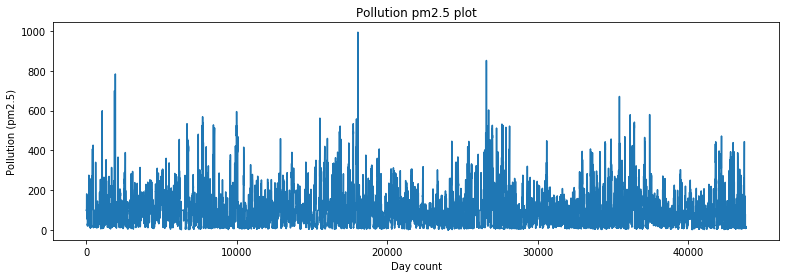

In [60]:

FIGURE_SIZE = (13, 5)

# Pollution plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["pm2.5"])
plt.xlabel('Day count')
plt.ylabel('Pollution (pm2.5)')
plt.title('Pollution pm2.5 plot')

plt.show()


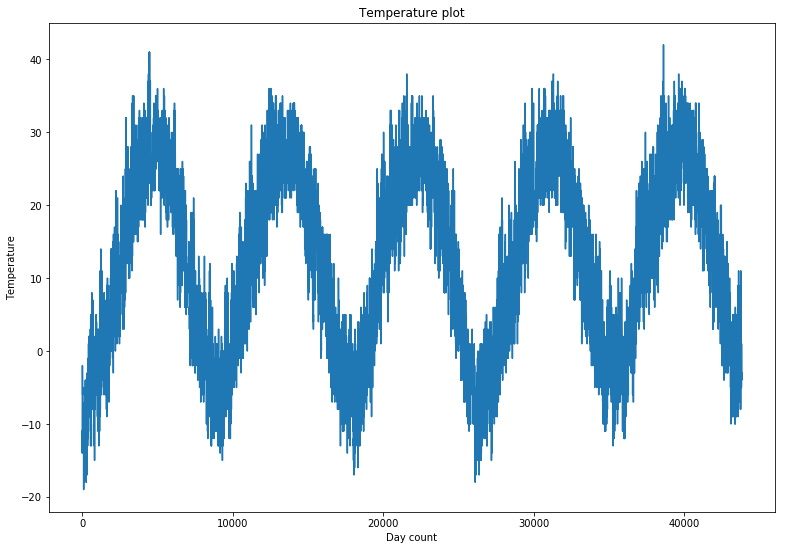

In [15]:

# Temperature plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Temperature"])
plt.xlabel('Day count')
plt.ylabel('Temperature')
plt.title('Temperature plot')

plt.show()


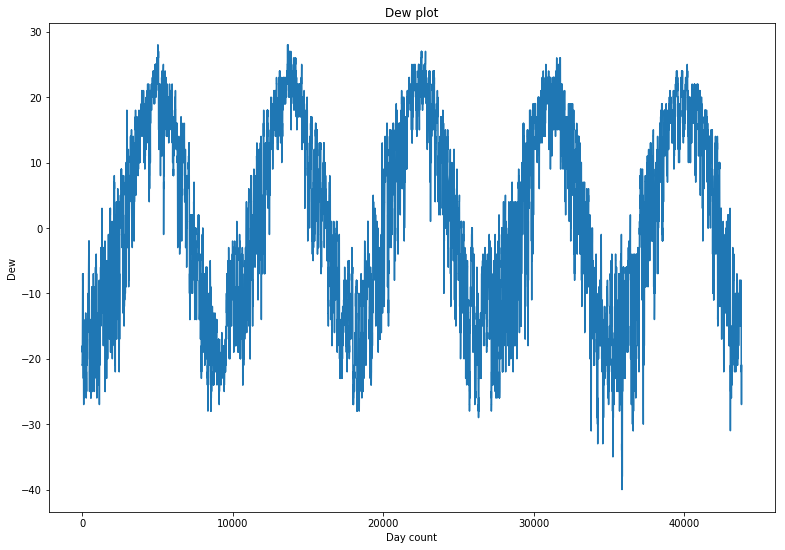

In [16]:

# Dew plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Dew"])
plt.xlabel('Day count')
plt.ylabel('Dew')
plt.title('Dew plot')

plt.show()


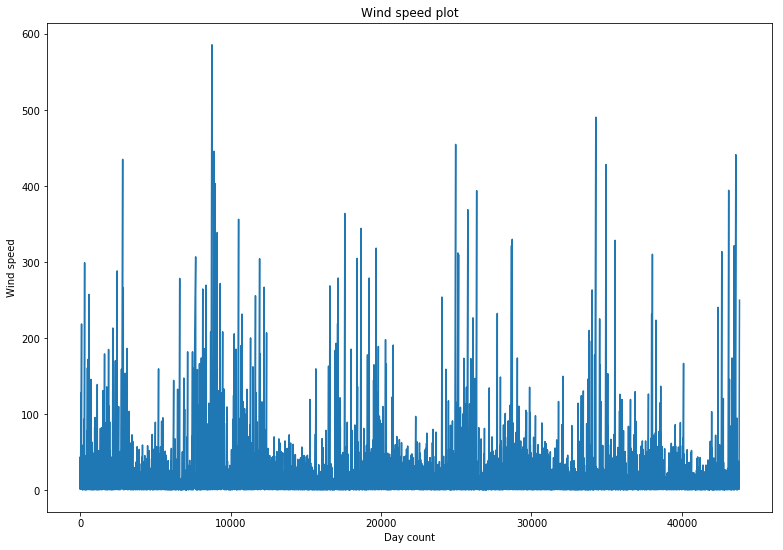

In [17]:

# Wind speed plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Wind_Speed"])
plt.xlabel('Day count')
plt.ylabel('Wind speed')
plt.title('Wind speed plot')

plt.show()


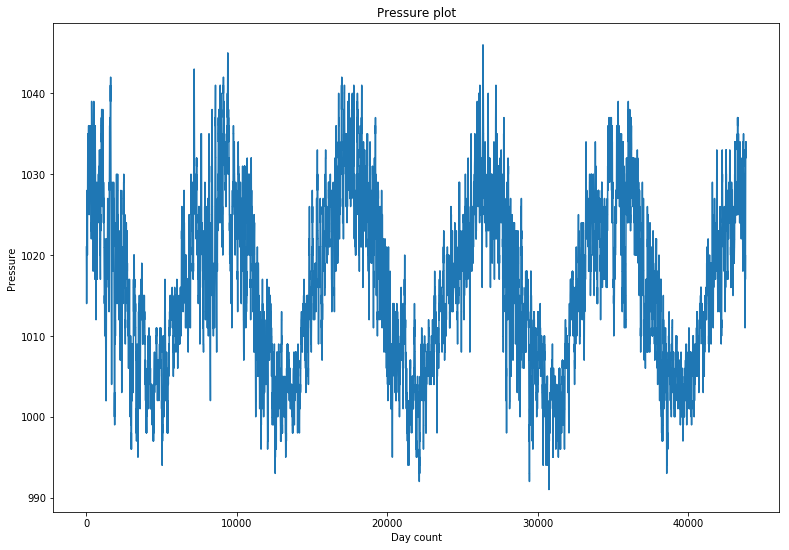

In [18]:

# Pressure plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Pressure"])
plt.xlabel('Day count')
plt.ylabel('Pressure')
plt.title('Pressure plot')

plt.show()


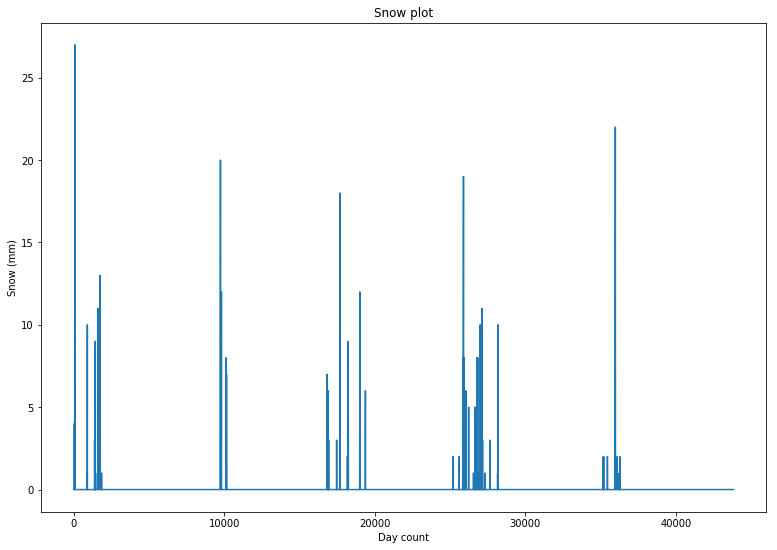

In [19]:

# Snow plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Snow"])
plt.xlabel('Day count')
plt.ylabel('Snow (mm)')
plt.title('Snow plot')

plt.show()


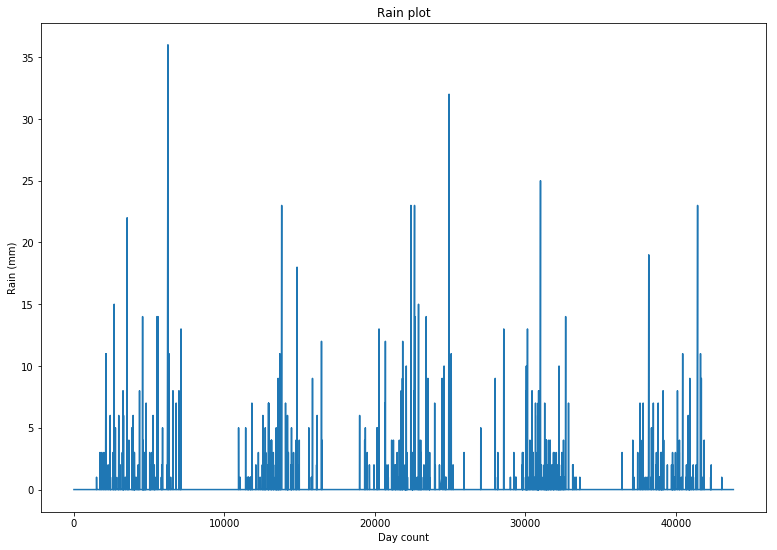

In [20]:

# Rain plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Rain"])
plt.xlabel('Day count')
plt.ylabel('Rain (mm)')
plt.title('Rain plot')

plt.show()


In [21]:

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression


D:\Applications\Python3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### b) Frame the task as the supervised learning problem as predicting the pollution at the current hour given the pollution measurement and weather conditions at the previous hour. Using the first 4 years' data as the training set and the remaining 1 year's data as the test set. Prepare the training/test sets accordingly.

In [22]:
from sklearn import preprocessing

# write your code here

pollution_df.head(HEAD_COUNT)

p_train_index = pollution_df[pollution_df["year"] < 2014].index
p_test_index = pollution_df[pollution_df["year"] == 2014].index

p_train = pollution_df.drop(p_test_index)
p_test = pollution_df.drop(p_train_index)


In [23]:
p_train.head(HEAD_COUNT)

,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
No,,,,,,,,,,,,
1,2010-01-01 00:00:00,2010,98.613215,-21,-11.0,1021.0,1.79,0,0,0,1,0
2,2010-01-01 01:00:00,2010,98.613215,-21,-12.0,1020.0,4.92,0,0,0,1,0
3,2010-01-01 02:00:00,2010,98.613215,-21,-11.0,1019.0,6.71,0,0,0,1,0
4,2010-01-01 03:00:00,2010,98.613215,-21,-14.0,1019.0,9.84,0,0,0,1,0
5,2010-01-01 04:00:00,2010,98.613215,-20,-12.0,1018.0,12.97,0,0,0,1,0
6,2010-01-01 05:00:00,2010,98.613215,-19,-10.0,1017.0,16.10,0,0,0,1,0
7,2010-01-01 06:00:00,2010,98.613215,-19,-9.0,1017.0,19.23,0,0,0,1,0
8,2010-01-01 07:00:00,2010,98.613215,-19,-9.0,1017.0,21.02,0,0,0,1,0
9,2010-01-01 08:00:00,2010,98.613215,-19,-9.0,1017.0,24.15,0,0,0,1,0


In [24]:
p_test.head(HEAD_COUNT)

,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
No,,,,,,,,,,,,
35065,2014-01-01 00:00:00,2014,24.0,-20,7.0,1014.0,143.48,0,0,0,1,0
35066,2014-01-01 01:00:00,2014,53.0,-20,7.0,1013.0,147.50,0,0,0,1,0
35067,2014-01-01 02:00:00,2014,65.0,-20,6.0,1013.0,151.52,0,0,0,1,0
35068,2014-01-01 03:00:00,2014,70.0,-20,6.0,1013.0,153.31,0,0,0,1,0
35070,2014-01-01 05:00:00,2014,92.0,-18,4.0,1012.0,4.02,0,0,0,1,0
35071,2014-01-01 06:00:00,2014,106.0,-19,6.0,1012.0,8.94,0,0,0,1,0
35072,2014-01-01 07:00:00,2014,75.0,-19,6.0,1013.0,16.09,0,0,0,1,0
35073,2014-01-01 08:00:00,2014,58.0,-18,6.0,1013.0,21.90,0,0,0,1,0
35074,2014-01-01 09:00:00,2014,33.0,-18,7.0,1014.0,26.82,0,0,0,1,0


The heads of the train and test dataset is printed to ensure the split has happened correctly. **2010** to **2013** for train and **2014** for test. 

**Train set: p_train**<br>
**Test set: p_test**

In [25]:

x_train_p = p_train.drop(columns=["datetime", "year"])
x_test_p = p_test.drop(columns=["datetime", "year"])


### Scaling all the columns 

Scaling is applied to both the **x_train** and **x_test** to make **x_train_scaled** and **x_test_scaled**.

In [26]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler

x_train_test_total = x_train_p.append(x_test_p)

scaler = StandardScaler().fit(x_train_test_total)
pm25_scaler = StandardScaler().fit(x_train_test_total["pm2.5"])

x_train_scaled = pd.DataFrame(scaler.transform(x_train_p), columns=x_train_p.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test_p), columns=x_test_p.columns)


D:\Applications\Python3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [27]:
x_train_scaled.head(HEAD_COUNT)

,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
0,0.083099,-1.502890,-1.896999,0.423379,-0.510659,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
1,0.083099,-1.502890,-1.977796,0.327938,-0.453626,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
2,0.083099,-1.502890,-1.896999,0.232497,-0.421010,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
3,0.083099,-1.502890,-2.139389,0.232497,-0.363977,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
4,0.083099,-1.434991,-1.977796,0.137056,-0.306945,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
5,0.083099,-1.367093,-1.816203,0.041615,-0.249912,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
6,0.083099,-1.367093,-1.735406,0.041615,-0.192879,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
7,0.083099,-1.367093,-1.735406,0.041615,-0.160263,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
8,0.083099,-1.367093,-1.735406,0.041615,-0.103231,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
9,0.083099,-1.434991,-1.654610,0.041615,-0.046198,-0.073355,-0.140993,-0.411989,1.197376,-0.893621


In [28]:
x_train_unscaled = pd.DataFrame(scaler.inverse_transform(x_train_scaled), columns=x_train_scaled.columns)
x_train_unscaled.head(HEAD_COUNT)

,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
0,98.613215,-21.0,-11.0,1021.0,1.79,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
1,98.613215,-21.0,-12.0,1020.0,4.92,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
2,98.613215,-21.0,-11.0,1019.0,6.71,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
3,98.613215,-21.0,-14.0,1019.0,9.84,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
4,98.613215,-20.0,-12.0,1018.0,12.97,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
5,98.613215,-19.0,-10.0,1017.0,16.10,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
6,98.613215,-19.0,-9.0,1017.0,19.23,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
7,98.613215,-19.0,-9.0,1017.0,21.02,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
8,98.613215,-19.0,-9.0,1017.0,24.15,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
9,98.613215,-20.0,-8.0,1017.0,27.28,-6.938894e-18,2.775558e-17,0.0,1.0,0.0


In [29]:
x_test_scaled.head(HEAD_COUNT)

,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
0,-0.783787,-1.434991,-0.442662,-0.244708,2.071115,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
1,-0.446853,-1.434991,-0.442662,-0.340149,2.144365,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
2,-0.307432,-1.434991,-0.523459,-0.340149,2.217614,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
3,-0.249340,-1.434991,-0.523459,-0.340149,2.250231,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
4,0.006264,-1.299194,-0.685052,-0.435590,-0.470025,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
5,0.168922,-1.367093,-0.523459,-0.435590,-0.380376,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
6,-0.191249,-1.367093,-0.523459,-0.340149,-0.250094,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
7,-0.388761,-1.299194,-0.523459,-0.340149,-0.144229,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
8,-0.679221,-1.299194,-0.442662,-0.244708,-0.054580,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
9,-0.470090,-1.299194,-0.361866,-0.149267,0.035069,-0.073355,-0.140993,-0.411989,1.197376,-0.893621


In [30]:
x_test_unscaled = pd.DataFrame(scaler.inverse_transform(x_test_scaled), columns=x_test_scaled.columns)
x_test_unscaled.head(HEAD_COUNT)

,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
0,24.0,-20.0,7.0,1014.0,143.48,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
1,53.0,-20.0,7.0,1013.0,147.50,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
2,65.0,-20.0,6.0,1013.0,151.52,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
3,70.0,-20.0,6.0,1013.0,153.31,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
4,92.0,-18.0,4.0,1012.0,4.02,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
5,106.0,-19.0,6.0,1012.0,8.94,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
6,75.0,-19.0,6.0,1013.0,16.09,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
7,58.0,-18.0,6.0,1013.0,21.90,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
8,33.0,-18.0,7.0,1014.0,26.82,-6.938894e-18,2.775558e-17,0.0,1.0,0.0
9,51.0,-18.0,8.0,1015.0,31.74,-6.938894e-18,2.775558e-17,0.0,1.0,0.0


In [31]:
# Sanity check to make sure their length is correct
print("train length: {}".format(len(x_train_scaled)))
print("test length: {}".format(len(x_test_scaled)))

train length: 27756
test length: 6681


In [32]:

y_train = pd.DataFrame(x_train_scaled["pm2.5"].shift(periods=-1))
y_test = pd.DataFrame(x_test_scaled["pm2.5"].shift(periods=-1))


Removing the last element of all the train and test sets as it's NaN

In [33]:

x_train_scaled = x_train_scaled[:-1]
x_test_scaled = x_test_scaled[:-1]

y_train = y_train[:-1]
y_test = y_test[:-1]


In [34]:

x_train = x_train_scaled.values
x_test = x_test_scaled.values

y_train = y_train.values
y_test = y_test.values


In [35]:
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.1

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = VAL_SIZE, random_state=200)

# train_val_set = x_train_scaled
# train_val_set["y"] = y_train

# test_set = x_test_scaled
# test_set["y"] = y_test




In [36]:

print(x_train[:10])
print(y_train[:10])



[[-0.85349705 -1.3670927  -1.81620298  1.85499262 -0.27451075 -0.0733551
  -0.14099345 -0.41198914  1.1973764  -0.89362102]
 [-0.93482582 -1.3670927  -1.8969995   1.66411075 -0.43740904 -0.0733551
  -0.14099345  2.42724843 -0.83515927 -0.89362102]
 [ 0.08309914 -1.70658514 -1.57381344  1.56866982  3.51278343 -0.0733551
  -0.14099345 -0.41198914  1.1973764  -0.89362102]
 [-0.38876124  0.73776045 -0.03867966 -0.91279438 -0.51065861 -0.0733551
   4.5867488   2.42724843 -0.83515927 -0.89362102]
 [-1.00453619 -0.07702142  0.20370989  0.32793772  1.98164881 -0.0733551
  -0.14099345 -0.41198914  1.1973764  -0.89362102]
 [ 0.08309914  1.48464382  0.85008201 -1.38999904 -0.51065861 -0.0733551
  -0.14099345 -0.41198914  1.1973764  -0.89362102]
 [-0.89997064  1.21304987  1.65804715 -1.96264462 -0.39677557 -0.0733551
  -0.14099345  2.42724843 -0.83515927 -0.89362102]
 [ 0.71498632  0.12667405 -0.60425526 -0.3401488  -0.41299252 -0.0733551
  -0.14099345 -0.41198914  1.1973764  -0.89362102]
 [ 0.505

In [37]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(24979, 10)
(24979, 1)
(2776, 10)
(2776, 1)
(6680, 10)
(6680, 1)


In [38]:

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))



In [39]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(24979, 1, 10)
(24979, 1)
(2776, 1, 10)
(2776, 1)
(6680, 1, 10)
(6680, 1)


### c) Train a Recurrent Neural Network (RNN) on the training set. You can split the training set further by using 10% of the data as the validation set and the remaining for training.

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout

FIGURE_SIZE = (13, 4)

BATCH_SIZE = 512
EPOCHS = 200

# write your code here
# design network
model = Sequential()

model.add(LSTM(400, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=2, shuffle=False)


Train on 24979 samples, validate on 2776 samples
Epoch 1/200
 - 3s - loss: 0.5462 - val_loss: 0.2238
Epoch 2/200
 - 0s - loss: 0.1430 - val_loss: 0.1034
Epoch 3/200
 - 0s - loss: 0.1128 - val_loss: 0.0974
Epoch 4/200
 - 0s - loss: 0.1100 - val_loss: 0.0963
Epoch 5/200
 - 0s - loss: 0.1089 - val_loss: 0.0958
Epoch 6/200
 - 0s - loss: 0.1083 - val_loss: 0.0956
Epoch 7/200
 - 0s - loss: 0.1080 - val_loss: 0.0956
Epoch 8/200
 - 0s - loss: 0.1078 - val_loss: 0.0955
Epoch 9/200
 - 0s - loss: 0.1077 - val_loss: 0.0955
Epoch 10/200
 - 0s - loss: 0.1076 - val_loss: 0.0955
Epoch 11/200
 - 0s - loss: 0.1076 - val_loss: 0.0955
Epoch 12/200
 - 0s - loss: 0.1075 - val_loss: 0.0955
Epoch 13/200
 - 0s - loss: 0.1075 - val_loss: 0.0954
Epoch 14/200
 - 0s - loss: 0.1075 - val_loss: 0.0954
Epoch 15/200
 - 0s - loss: 0.1074 - val_loss: 0.0954
Epoch 16/200
 - 0s - loss: 0.1074 - val_loss: 0.0954
Epoch 17/200
 - 0s - loss: 0.1074 - val_loss: 0.0954
Epoch 18/200
 - 0s - loss: 0.1074 - val_loss: 0.0954
Epoch 

Epoch 154/200
 - 0s - loss: 0.1051 - val_loss: 0.0950
Epoch 155/200
 - 0s - loss: 0.1051 - val_loss: 0.0949
Epoch 156/200
 - 0s - loss: 0.1050 - val_loss: 0.0949
Epoch 157/200
 - 0s - loss: 0.1050 - val_loss: 0.0949
Epoch 158/200
 - 0s - loss: 0.1050 - val_loss: 0.0949
Epoch 159/200
 - 0s - loss: 0.1050 - val_loss: 0.0949
Epoch 160/200
 - 0s - loss: 0.1050 - val_loss: 0.0949
Epoch 161/200
 - 0s - loss: 0.1050 - val_loss: 0.0949
Epoch 162/200
 - 0s - loss: 0.1050 - val_loss: 0.0949
Epoch 163/200
 - 0s - loss: 0.1050 - val_loss: 0.0949
Epoch 164/200
 - 0s - loss: 0.1049 - val_loss: 0.0948
Epoch 165/200
 - 0s - loss: 0.1049 - val_loss: 0.0948
Epoch 166/200
 - 0s - loss: 0.1049 - val_loss: 0.0948
Epoch 167/200
 - 0s - loss: 0.1049 - val_loss: 0.0948
Epoch 168/200
 - 0s - loss: 0.1049 - val_loss: 0.0948
Epoch 169/200
 - 0s - loss: 0.1049 - val_loss: 0.0948
Epoch 170/200
 - 0s - loss: 0.1049 - val_loss: 0.0948
Epoch 171/200
 - 0s - loss: 0.1048 - val_loss: 0.0948
Epoch 172/200
 - 0s - loss: 

The plot below shows the training and the test losses 

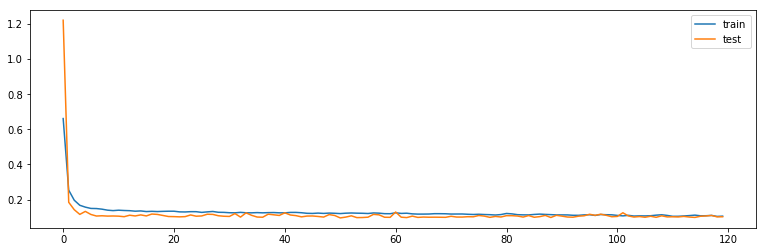

In [61]:
# plot history
plt.figure(figsize=FIGURE_SIZE)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

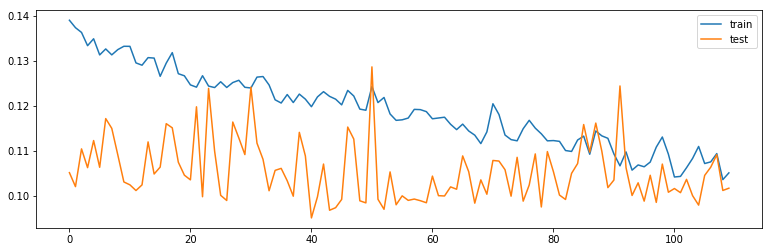

In [62]:
plt.figure(figsize=FIGURE_SIZE)
plt.plot(history.history['loss'][10:], label='train')
plt.plot(history.history['val_loss'][10:], label='test')
plt.legend()
plt.show()

### d) Output the prediction results such as Root Mean Squared Errors (RMSE) on the test set. Remember that after the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with other models. Plot the predicted values vs. the actual values.

In [43]:
from sklearn.metrics import mean_squared_error

# write your code here


In [44]:

def predict_and_score(_model, x, y):
    # Make predictions on the original scale of the data.
    y_hat = _model.predict(x)
    
    pred = pm25_scaler.inverse_transform(y_hat)
    y_inv_scaled = pm25_scaler.inverse_transform(y)
    
    x_actual_inv_scaled = scaler.inverse_transform(x)
    x_actual_inv_scaled = x_actual_inv_scaled.T[0].T
  
    score = math.sqrt(mean_squared_error(y_inv_scaled, pred))
    
    return(score, pred, x_actual_inv_scaled)


In [45]:

rmse_train, train_predict, train_actual = predict_and_score(model, x_train, y_train)
rmse_test, test_predict, test_actual = predict_and_score(model, x_test, y_test)


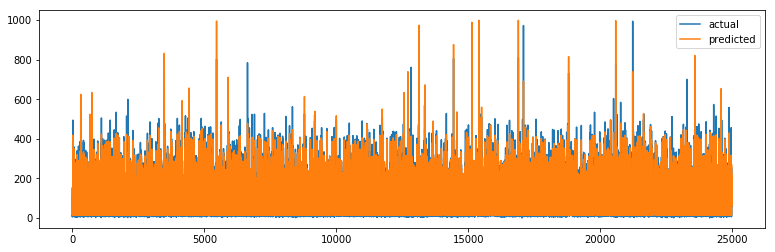

In [63]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(train_actual, label='actual')
plt.plot(train_predict, label='predicted')

plt.legend()
plt.show()


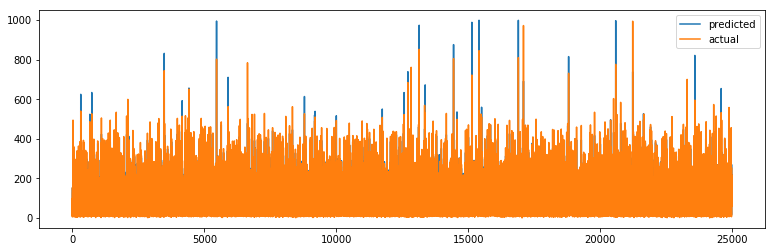

In [64]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(train_predict, label='predicted')
plt.plot(train_actual, label='actual')

plt.legend()
plt.show()


### e) Explore different network architectures (e.g., stacked LSTM layers) and various ways in tuning the model parameters to see if you can improve the model performance on the test set. 

In [48]:


EPOCHS=120
BATCH_SIZE = 512

model_complex = Sequential()
model_complex.add(LSTM(400, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.2))

model_complex.add(LSTM(400, return_sequences=True))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.2))

model_complex.add(LSTM(400, return_sequences=True))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.2))

model_complex.add(LSTM(400, activation='relu'))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.2))

model_complex.add(Dense(500))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.1))

model_complex.add(Dense(500))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.1))

model_complex.add(Dense(20))

model_complex.add(Dense(1))


model_complex.compile(loss='mse', optimizer='adam')

# fit network
history = model_complex.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=2, shuffle=False)

Train on 24979 samples, validate on 2776 samples
Epoch 1/120
 - 8s - loss: 0.6613 - val_loss: 1.2216
Epoch 2/120
 - 2s - loss: 0.2533 - val_loss: 0.1841
Epoch 3/120
 - 2s - loss: 0.1959 - val_loss: 0.1418
Epoch 4/120
 - 2s - loss: 0.1671 - val_loss: 0.1151
Epoch 5/120
 - 2s - loss: 0.1565 - val_loss: 0.1322
Epoch 6/120
 - 2s - loss: 0.1491 - val_loss: 0.1148
Epoch 7/120
 - 2s - loss: 0.1484 - val_loss: 0.1058
Epoch 8/120
 - 2s - loss: 0.1449 - val_loss: 0.1072
Epoch 9/120
 - 2s - loss: 0.1393 - val_loss: 0.1055
Epoch 10/120
 - 2s - loss: 0.1367 - val_loss: 0.1060
Epoch 11/120
 - 2s - loss: 0.1390 - val_loss: 0.1051
Epoch 12/120
 - 2s - loss: 0.1373 - val_loss: 0.1020
Epoch 13/120
 - 2s - loss: 0.1363 - val_loss: 0.1104
Epoch 14/120
 - 2s - loss: 0.1333 - val_loss: 0.1062
Epoch 15/120
 - 2s - loss: 0.1349 - val_loss: 0.1123
Epoch 16/120
 - 2s - loss: 0.1313 - val_loss: 0.1063
Epoch 17/120
 - 2s - loss: 0.1326 - val_loss: 0.1171
Epoch 18/120
 - 2s - loss: 0.1313 - val_loss: 0.1150
Epoch 

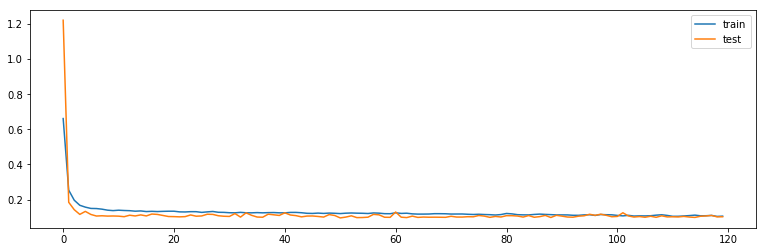

In [65]:

# write your code here
plt.figure(figsize=FIGURE_SIZE)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


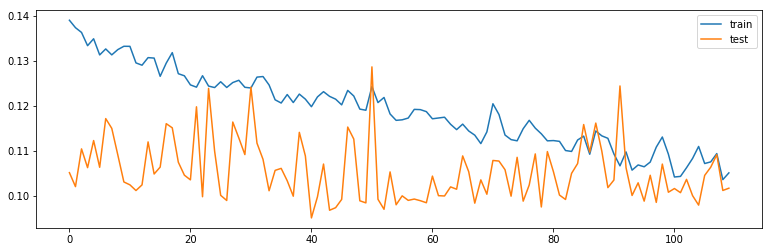

In [66]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(history.history['loss'][10:], label='train')
plt.plot(history.history['val_loss'][10:], label='test')
plt.legend()
plt.show()


In [51]:
rmse_train, train_predict, train_actual = predict_and_score(model_complex, x_train, y_train)
rmse_test, test_predict, test_actual = predict_and_score(model_complex, x_test, y_test)

In [52]:
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))

RMSE Train: 26.824027405333215
RMSE Test: 29.021233294373555


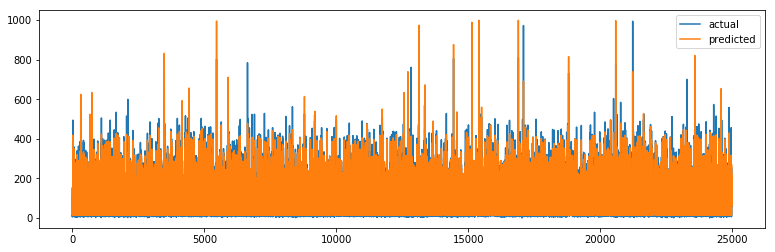

In [67]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(train_actual, label='actual')
plt.plot(train_predict, label='predicted')

plt.legend()
plt.show()


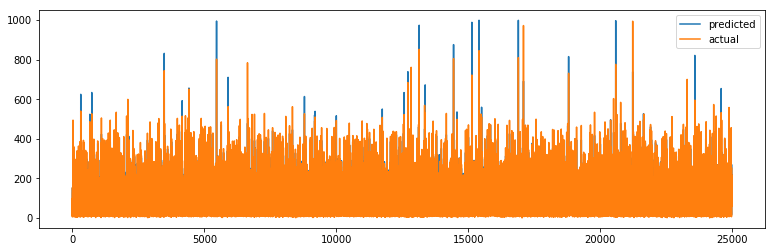

In [68]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(train_predict, label='predicted')
plt.plot(train_actual, label='actual')

plt.legend()
plt.show()


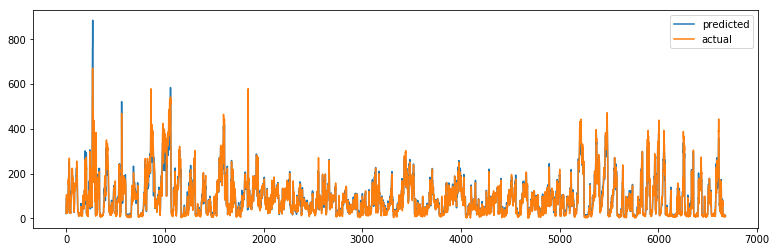

In [69]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(test_predict, label='predicted')
plt.plot(test_actual, label='actual')

plt.legend()
plt.show()


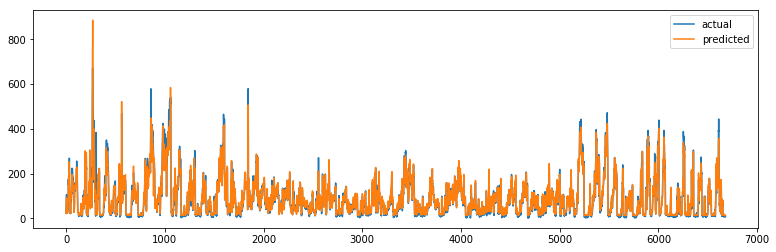

In [70]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(test_actual, label='actual')
plt.plot(test_predict, label='predicted')

plt.legend()
plt.show()


f) Explore alterative prediction setup by predicting the pollution for the next hour based on the weather conditions and pollution over the last 3 days.

In [57]:
# write your code here